In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
data_1 = pd.read_csv("/Users/calebjonesshibu/Desktop/tom/derived/draft_2023_06_05_11/nirs/exp_2022_09_30_10/leopard_affective_individual_physio_task.csv")
data_2 = pd.read_csv("/Users/calebjonesshibu/Desktop/tom/derived/draft_2023_06_05_11/nirs/exp_2022_09_30_10/lion_affective_individual_physio_task.csv")
data_3 = pd.read_csv("/Users/calebjonesshibu/Desktop/tom/derived/draft_2023_06_05_11/nirs/exp_2022_09_30_10/tiger_affective_individual_physio_task.csv")

In [3]:
data_1.drop(columns=['unix_time', 'task_time', 'task_monotonic_time', 'task_human_readable_time', 'task_subject_id', 'seconds_since_start', 'human_readable_time', 'leopard', 'task_index', 'experiment_id'], inplace=True)
data_2.drop(columns=['unix_time', 'task_time', 'task_monotonic_time', 'task_human_readable_time', 'task_subject_id', 'seconds_since_start', 'human_readable_time', 'lion', 'task_index', 'experiment_id'], inplace=True)
data_3.drop(columns=['unix_time', 'task_time', 'task_monotonic_time', 'task_human_readable_time', 'task_subject_id', 'seconds_since_start', 'human_readable_time', 'tiger', 'task_index', 'experiment_id'], inplace=True)

In [4]:
#fill NaNs to 'task_arousal_score', 'task_valence_score' with task_event_type == 'intermediate_selection'
data_1.loc[data_1['task_event_type'] == 'intermediate_selection', ['task_arousal_score', 'task_valence_score']] = np.nan
data_2.loc[data_2['task_event_type'] == 'intermediate_selection', ['task_arousal_score', 'task_valence_score']] = np.nan
data_3.loc[data_3['task_event_type'] == 'intermediate_selection', ['task_arousal_score', 'task_valence_score']] = np.nan


In [5]:
# Backfill 'task_arousal_score', 'task_valence_score' when task_event_type == 'final_submission'
data_1[['task_image_path', 'task_arousal_score', 'task_valence_score', 'task_event_type']] = data_1[['task_image_path', 'task_arousal_score', 'task_valence_score', 'task_event_type']].fillna(method='bfill')
data_2[['task_image_path', 'task_arousal_score', 'task_valence_score', 'task_event_type']] = data_2[['task_image_path', 'task_arousal_score', 'task_valence_score', 'task_event_type']].fillna(method='bfill')
data_3[['task_image_path', 'task_arousal_score', 'task_valence_score', 'task_event_type']] = data_3[['task_image_path', 'task_arousal_score', 'task_valence_score', 'task_event_type']].fillna(method='bfill')

In [6]:
data_1.dropna(inplace=True)
data_2.dropna(inplace=True)
data_3.dropna(inplace=True)

In [7]:
data_1.drop(columns=['task_image_path', 'task_event_type'], inplace=True)
data_2.drop(columns=['task_image_path', 'task_event_type'], inplace=True)
data_3.drop(columns=['task_image_path', 'task_event_type'], inplace=True)

In [8]:
# Resetting the column names to None for each dataframe
data_1.columns = [None] * len(data_1.columns)
data_2.columns = [None] * len(data_2.columns)
data_3.columns = [None] * len(data_3.columns)

# Concatenating the dataframes vertically
merged_df = pd.concat([data_1, data_2, data_3], ignore_index=True)


In [9]:
headers = [
    "S1-D1_HbO", "S1-D2_HbO", "S2-D1_HbO", "S2-D3_HbO", "S3-D1_HbO",
    "S3-D3_HbO", "S3-D4_HbO", "S4-D2_HbO", "S4-D4_HbO", "S4-D5_HbO",
    "S5-D3_HbO", "S5-D4_HbO", "S5-D6_HbO", "S6-D4_HbO", "S6-D6_HbO",
    "S6-D7_HbO", "S7-D5_HbO", "S7-D7_HbO", "S8-D6_HbO", "S8-D7_HbO",
    "S1-D1_HbR", "S1-D2_HbR", "S2-D1_HbR", "S2-D3_HbR", "S3-D1_HbR",
    "S3-D3_HbR", "S3-D4_HbR", "S4-D2_HbR", "S4-D4_HbR", "S4-D5_HbR",
    "S5-D3_HbR", "S5-D4_HbR", "S5-D6_HbR", "S6-D4_HbR", "S6-D6_HbR",
    "S6-D7_HbR", "S7-D5_HbR", "S7-D7_HbR", "S8-D6_HbR", "S8-D7_HbR", 
    "arousal_score", "valence_score"
]
merged_df = merged_df.set_axis(headers, axis=1)

In [10]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [72]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess data
features = merged_df.iloc[:, :-2].values
arousal_score = LabelEncoder().fit_transform(merged_df.iloc[:, -2] + 2)  # Mapping -2 -> 0, -1 -> 1, 0 -> 2, 1 -> 3, 2 -> 4
valence_score = LabelEncoder().fit_transform(merged_df.iloc[:, -1] + 2)  # Same mapping for valence_score
targets = list(zip(arousal_score, valence_score))

# Split data
train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

# Hyperparameters
input_size = features.shape[1]
hidden_size = 64
num_classes = 5  # Classes representing -2, -1, 0, 1, 2
num_epochs = 1000
batch_size = 32
learning_rate = 0.001

# Create DataLoaders
train_data = TensorDataset(torch.tensor(train_features).float().to(device), torch.tensor(train_targets).long().to(device))
test_data = TensorDataset(torch.tensor(test_features).float().to(device), torch.tensor(test_targets).long().to(device))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize model, loss, and optimizer
model = LSTM(input_size, hidden_size, num_classes).to(device)  # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.view(-1, 1, input_size)
        targets_arousal = targets[:, 0]
        targets_valence = targets[:, 1]

        outputs = model(inputs)

        loss_arousal = criterion(outputs, targets_arousal)
        loss_valence = criterion(outputs, targets_valence)

        loss = loss_arousal + loss_valence  # Total loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Testing
correct_arousal, correct_valence = 0, 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.view(-1, 1, input_size)
        targets_arousal = targets[:, 0]
        targets_valence = targets[:, 1]
        
        outputs = model(inputs)

        _, predicted_arousal = torch.max(outputs.data, 1)
        _, predicted_valence = torch.max(outputs.data, 1)

        total += targets.size(0)
        correct_arousal += (predicted_arousal == targets_arousal).sum().item()
        correct_valence += (predicted_valence == targets_valence).sum().item()

print(f'Accuracy of the network on the test data for arousal_score: {100 * correct_arousal / total} %')
print(f'Accuracy of the network on the test data for valence_score: {100 * correct_valence / total} %')

Epoch 10/1000, Loss: 1.4146275520324707
Epoch 20/1000, Loss: 1.753422737121582
Epoch 30/1000, Loss: 1.2336524724960327
Epoch 40/1000, Loss: 1.2750574350357056
Epoch 50/1000, Loss: 1.3150863647460938
Epoch 60/1000, Loss: 1.2093348503112793
Epoch 70/1000, Loss: 1.2408185005187988
Epoch 80/1000, Loss: 1.0053539276123047
Epoch 90/1000, Loss: 1.3651790618896484
Epoch 100/1000, Loss: 1.334029197692871
Epoch 110/1000, Loss: 1.109188437461853
Epoch 120/1000, Loss: 1.0301941633224487
Epoch 130/1000, Loss: 1.0004347562789917
Epoch 140/1000, Loss: 1.1032227277755737
Epoch 150/1000, Loss: 1.2053205966949463
Epoch 160/1000, Loss: 1.1237409114837646
Epoch 170/1000, Loss: 1.1960358619689941
Epoch 180/1000, Loss: 0.9522440433502197
Epoch 190/1000, Loss: 0.9956511855125427
Epoch 200/1000, Loss: 0.9995516538619995
Epoch 210/1000, Loss: 0.9424712657928467
Epoch 220/1000, Loss: 1.1944994926452637
Epoch 230/1000, Loss: 1.3012149333953857
Epoch 240/1000, Loss: 1.0925474166870117
Epoch 250/1000, Loss: 1.3908

Fold 1/5
Epoch 10/10, Loss: 2.1788594722747803
Fold 2/5
Epoch 10/10, Loss: 1.5521869659423828
Fold 3/5
Epoch 10/10, Loss: 1.0089495182037354
Fold 4/5
Epoch 10/10, Loss: 1.2936415672302246
Fold 5/5
Epoch 10/10, Loss: 1.2802364826202393
Average accuracy for arousal_score: 55.75777929721541
Standard deviation for arousal_score: 4.0242982639874985
Average accuracy for valence_score: 61.93970513972123
Standard deviation for valence_score: 2.260024175119987


ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

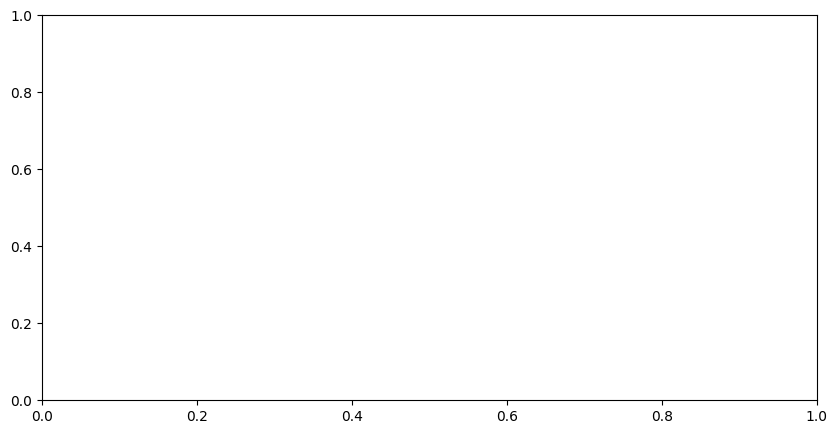

In [53]:
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess data
features = merged_df.iloc[:, :-2].values
arousal_score = LabelEncoder().fit_transform(merged_df.iloc[:, -2] + 2)  # Mapping -2 -> 0, -1 -> 1, 0 -> 2, 1 -> 3, 2 -> 4
valence_score = LabelEncoder().fit_transform(merged_df.iloc[:, -1] + 2)  # Same mapping for valence_score
targets = list(zip(arousal_score, valence_score))

# Hyperparameters
input_size = features.shape[1]
hidden_size = 64
num_classes = 5  # Classes representing -2, -1, 0, 1, 2
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_folds = 5

# Create DataLoaders
dataset = TensorDataset(torch.tensor(features).float().to(device), torch.tensor(targets).long().to(device))
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize model, loss, and optimizer
model = LSTM(input_size, hidden_size, num_classes).to(device)  # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Perform k-fold cross-validation
fold_losses = []
fold_accuracies = []

for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}/{num_folds}")

    # Split data into train and test sets for the current fold
    train_data = Subset(dataset, train_indices)
    test_data = Subset(dataset, test_indices)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Training
    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.view(-1, 1, input_size)
            targets_arousal = targets[:, 0]
            targets_valence = targets[:, 1]

            outputs = model(inputs)

            loss_arousal = criterion(outputs, targets_arousal)
            loss_valence = criterion(outputs, targets_valence)

            loss = loss_arousal + loss_valence  # Total loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    fold_losses.append(loss.item())

    # Testing
    model.eval()
    correct_arousal, correct_valence = 0, 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(-1, 1, input_size)
            targets_arousal = targets[:, 0]
            targets_valence = targets[:, 1]

            outputs = model(inputs)

            _, predicted_arousal = torch.max(outputs.data, 1)
            _, predicted_valence = torch.max(outputs.data, 1)

            total += targets.size(0)
            correct_arousal += (predicted_arousal == targets_arousal).sum().item()
            correct_valence += (predicted_valence == targets_valence).sum().item()

    accuracy_arousal = 100 * correct_arousal / total
    accuracy_valence = 100 * correct_valence / total
    fold_accuracies.append((accuracy_arousal, accuracy_valence))

# Print average accuracy and standard deviation across folds
arousal_accuracies, valence_accuracies = zip(*fold_accuracies)
print("Average accuracy for arousal_score:", np.mean(arousal_accuracies))
print("Standard deviation for arousal_score:", np.std(arousal_accuracies))
print("Average accuracy for valence_score:", np.mean(valence_accuracies))
print("Standard deviation for valence_score:", np.std(valence_accuracies))
